In [1]:
import xarray as xr
import rioxarray as rx
import numpy as np
from glob import glob
import os
from datetime import datetime as dt
from matplotlib import pyplot as plt
import scipy.optimize as optimize
import geopandas as gpd
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression

In [2]:
os.chdir('/exports/csce/datastore/geos/users/s1332488/Chapter3/S1')

In [3]:
def CSR(a):
    mean = np.mean(a, axis=0)
    resid = a - mean
    return np.nancumsum(resid,axis=0)

def get_max_CSR(a):
    return xr.apply_ufunc(CSR, a).max(dim='t')

def get_min_CSR(a):
    return xr.apply_ufunc(CSR,a).min(dim='t')

def get_pixelsize(ds):
    metres = ds.rename({'lat':'y','lon':'x'}).rio.reproject('EPSG:5389')
    print((metres.x[1]-metres.x[0]).values)

In [4]:
VV = rx.open_rasterio('S1_BelgicaVV.tif').rio.reproject('EPSG:4326')
VH = rx.open_rasterio('S1_BelgicaVH.tif').rio.reproject('EPSG:4326')

uav = '/exports/csce/datastore/geos/users/s1332488/Chapter3/intensity/UAV_change_1m_masked.tif'
uav = rx.open_rasterio(uav)
uav = uav.sel(band=1).drop('band').rio.reproject('EPSG:4326').rename({'x':'lon','y':'lat'})
uav = uav.coarsen(lat=10,lon=10,boundary='trim').mean()

def prepare(ds):
    ds = ds.rename({'x':'lon','y':'lat','band':'t'})
    AOI_lon, AOI_lat = slice(-69.73,-69.705) , slice(-11.015,-11.035)
    ds = ds.sel(lon=AOI_lon, lat=AOI_lat)   # Crop to AOI
    keep  = 3*np.array([0,1,2,3,4,5,6,6,7,8,10,11,12,13,14,15,18,19,20,21])
    ds   = ds.isel(t=keep)
    csr = get_max_CSR(ds)                                             # Change detection feature height
    return csr

def prepare_all(ds):
    ds = ds.rename({'x':'lon','y':'lat','band':'t'})
    AOI_lon, AOI_lat = slice(-69.73,-69.705) , slice(-11.015,-11.035)
    ds = ds.sel(lon=AOI_lon, lat=AOI_lat)   # Crop to AOI
    csr = get_max_CSR(ds)                                             # Change detection feature height
    return csr

/exports/csce/datastore/geos/users/s1332488/minibonda/envs/XR/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [9]:
csrVV= prepare(VV)
csrVH = prepare(VH)
csrVH = csrVH.interp_like(csrVV)
s1 = xr.merge([csrVV.rename('x0'),
               csrVH.rename('x1'),
               uav.interp_like(csrVV,method='nearest').rename('uav')])

csrVV_all = prepare_all(VV)
csrVH_all = prepare_all(VH)
csrVH_all = csrVH_all.interp_like(csrVV_all)
s1_all = xr.merge([csrVV_all.rename('x0'),
                   csrVH_all.rename('x1'),
                   uav.interp_like(csrVV_all,method='nearest').rename('uav')])

s1 = s1.coarsen(lat=5,lon=5,boundary='trim').mean()
s1_all = s1_all.coarsen(lat=5,lon=5,boundary='trim').mean()
# Double check pixel sizes and extents
print('S1 pixel size')
get_pixelsize(s1)

get_pixelsize(s1_all)

def norm(da):
    return ( da - da.mean() )/ da.std()
s1['x0'] = norm(s1.x0)
s1['x1'] = norm(s1.x1)
s1_all['x0'] = norm(s1_all.x0)
s1_all['x1'] = norm(s1_all.x1)

S1 pixel size
49.05898141936632
49.05898141936632


In [10]:
# Read in training area and testing area
train_aoi = gpd.read_file('/home/s1332488/Chapter3/Figures/Ph_ts/train_area.shp')
test_aoi = gpd.read_file('/home/s1332488/Chapter3/Figures/Ph_ts/test.shp')

# Define routine to optimize linear model with two features as inputs (3 parameters)

def model(ds,p0,p1,p2):
    return p0 * ds.x0 + p1 * ds.x1 + p2

def cost_fn(p,ds):
    estimate = model(ds,p[0],p[1],p[2])
    return np.sqrt( ((estimate-ds.uav)**2).sum() ).values

def fit_model(ds):
    ds = ds[['uav','x0','x1']]
    trainData = ds.rio.clip(train_aoi.geometry).where(ds.uav > -100)
    result = optimize.minimize(cost_fn,[-1,-1,0],args=trainData)
    print(result.message)
    print('Parameters: ',result.x)
    p = result.x
    ds['pred'] = model(ds,p[0],p[1],p[2])    
    print('r = ',xr.corr(ds.uav,ds.pred).values)
    return ds.pred

def skl_fit(ds):
    ds = ds[['uav','x0','x1']]
    trainData = ds.rio.clip(train_aoi.geometry)
    x0 = trainData.x0.values.flatten()
    x1 = trainData.x1.values.flatten()
    y = trainData.uav.values.flatten()

    where = y>-100
    x0 = x0[where]
    x1 = x1[where]
    y = y[where]
    X = np.array([x0,x1]).transpose()
    reg = LinearRegression()
    reg.fit(X,y)

    print(reg.coef_,reg.intercept_)
    
    return lambda x: x.x0* reg.coef_[0] + x.x1*reg.coef_[1] + reg.intercept_



In [11]:
# dem['pred']=skl_fit(dem)(dem)
# intensity['pred']=skl_fit(intensity)(intensity)
# coh['pred'] = skl_fit(coh)(coh)

# s1['pred']=fit_model(s1)

# s1_all['pred'] = fit_model(s1_all)

s1['pred'] = skl_fit(s1)(s1)
s1_all['pred'] = skl_fit(s1_all)(s1_all)


[-0.15175612 -0.1919526 ] -0.37071829897912345
[-0.20604059 -0.16842591] -0.3736833729172472


comparable number of images
Detection Rate:  0.016666666666666666
false alarm rate:  0.5
Accuracy:  0.7938144329896907
all images
Detection Rate:  0.08333333333333333
false alarm rate:  0.4444444444444444
Accuracy:  0.7972508591065293


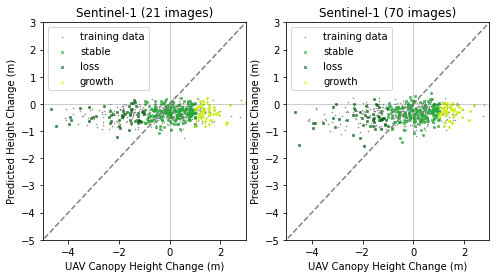

In [13]:
def plot_results(ds):
    ds.plot.scatter(x='uav',y='pred',s=1,color='grey',label='training data',marker='.')
    testData = ds.rio.clip(test_aoi.geometry).where(ds.uav > -100)
    noChange = testData.where((testData.uav >= -1)*(testData.uav <= 1))
    fall = testData.where(testData.uav<-1)
    grow = testData.where(testData.uav>1)
    noChange.plot.scatter(x='uav',y='pred',s=2,color='#22ab34',marker='s',alpha=0.5,label='stable')
    fall.plot.scatter(x='uav',y='pred',s=2,color='#00660e',marker='s',alpha=0.5,label='loss')
    grow.plot.scatter(x='uav',y='pred',s=2,color='#d4fc0d',marker='s',alpha=0.5,label='growth')
    plt.xlabel('UAV Canopy Height Change (m)')
    plt.ylabel('Predicted Height Change (m)')
    plt.axvline(x=0,alpha=0.2,lw=1,color='black')
    plt.axhline(y=0,alpha=0.2,lw=1,color='black')
#     plt.plot([1,1],[1,3],alpha=0.2,lw=1,color='black')
#     plt.plot([1,3],[1,1],alpha=0.2,lw=1,color='black')
#     plt.plot([-1,-1],[-1,-7],alpha=0.2,lw=1,color='black')
#     plt.plot([-1,-7],[-1,-1],alpha=0.2,lw=1,color='black')
    plt.plot([-7,3],[-7,3],color='grey',ls='--')
#     testData.plot.scatter(x='uav',y='pred',s=2)
    plt.xlim(-5,3)
    plt.ylim(-5,3)
    plt.legend()
    
    positives = ((testData.uav < -1)*(testData.uav > -100)).sum()
    flagged = (testData.pred < -1).sum()
    true_pos = ((testData.uav < -1) * (testData.pred < -1)).sum()
    detection_rate = true_pos/positives
    false_alarms = 1 - (true_pos/flagged)
    true_neg = ((testData.uav >= -1)* (testData.pred >= -1)).sum()
    accuracy = (true_pos + true_neg)/(testData.uav > -100).sum()
    print('Detection Rate: ',detection_rate.values)
    print('false alarm rate: ',false_alarms.values)
    print('Accuracy: ',accuracy.values)
    
    return plt.gca()
    
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
print('comparable number of images')
plot_results(s1)
plt.title('Sentinel-1 (21 images)')


plt.subplot(1,2,2)
print('all images')
plot_results(s1_all)
plt.title('Sentinel-1 (70 images)')
plt.savefig('/home/s1332488/Chapter3/Figures/S1change_detection.png',dpi=400)
plt.show()

In [146]:

print(xr.corr(s1_all.uav,s1_all.x1).values)

-0.017331121728809747


-0.22695764527661597


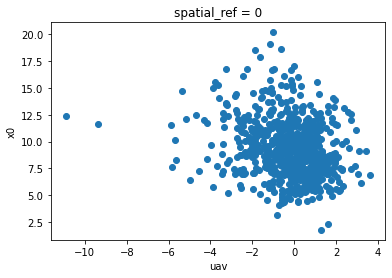

***
-0.2328398614889163


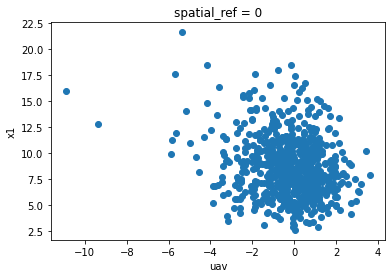

In [151]:
s1_all = s1_all.where(s1_all.uav > -100)
s1_all.plot.scatter(x='uav',y='x0')
print(xr.corr(s1_all.uav,s1_all.x0).values)
plt.show()
print('***')
s1_all.plot.scatter(x='uav',y='x1')
print(xr.corr(s1_all.uav,s1_all.x1).values)
plt.show()